In [1]:
# do imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import pickle
import pandas as pd
import seaborn as sns

In [4]:
#extract shoot and root data from csv files
reads = np.empty((22383, 166))
OTUs = np.empty(22383, dtype=str)
plate = np.empty(166, dtype=str)
OTU = []
f = open('figure2A_raw.csv', 'r')
i = 0
for line in f:
    line = line.strip()
    line = line.split(',')
    if line[0] == '""':
        for j in range(len(line)):
            line[j] = line[j][1:-1]
        plate = line[1::]
    else:
        reads[i] = line[1::]
        if line[0][1] == 'A':
            line[0] = line[0][1:-1]
            OTU.append(line[0])
        i += 1
OTUs = OTU
print(reads.shape)
root_ind = [[],[],[]]
shoot_ind = [[],[],[]]
soil_ind = [[],[],[]]
q = open('data_Fig2A_S2A.csv', 'r')
for row in q:
    row = row.strip()
    row = row.split(',')
    pos = row[0]+'_'+row[1]
    if row[6] == 'Col-0':
        if row[8] == 'Root':
            root_ind[0].append(plate.index(pos))
        if row[8] == 'Soil':
            soil_ind[0].append(plate.index(pos))
        if row[8] == 'Shoot':
            shoot_ind[0].append(plate.index(pos))
    if row[6] == 'phf1':
        if row[8] == 'Root':
            root_ind[1].append(plate.index(pos))
        if row[8] == 'Soil':
            soil_ind[1].append(plate.index(pos))
        if row[8] == 'Shoot':
            shoot_ind[1].append(plate.index(pos))
    if row[6] == 'phr1/phl1':
        if row[8] == 'Root':
            root_ind[2].append(plate.index(pos))
        if row[8] == 'Soil':
            soil_ind[2].append(plate.index(pos))
        if row[8] == 'Shoot':
            shoot_ind[2].append(plate.index(pos))
root_col = np.array(root_ind[0])
root_phf = np.array(root_ind[1])
root_phr = np.array(root_ind[2])
soil_col = np.array(soil_ind[0])
soil_phf = np.array(soil_ind[1])
soil_phr = np.array(soil_ind[2])
shoot_col = np.array(shoot_ind[0])
shoot_phf = np.array(shoot_ind[1])
shoot_phr = np.array(shoot_ind[2])


(22383, 166)


In [5]:
#rarefraction the data
from numpy.random import RandomState

def rarefaction(M, seed=0):
    prng = RandomState(seed) # reproducible results
    noccur = np.sum(M, axis=0) # number of occurrences for each sample
    nvar = M.shape[0] # number of variables
    #print(nvar)
    #depth = np.min(noccur) # sampling depth
    depth = 3000

    Mrarefied = np.empty_like(M)
    for i in range(M.shape[1]): # for each sample
        p = M[:,i] / float(noccur[i]) # relative frequency / probability
        choice = prng.choice(nvar, depth, p=p)
        Mrarefied[:,i] = np.bincount(choice, minlength=nvar)

    return Mrarefied

In [8]:
rare = rarefaction(reads, seed=130816)
print(rare)

[[131.   4.   2. ...   8.  39. 264.]
 [  0.   0.   0. ... 745.  12.   4.]
 [  0.   0.   0. ...   4.   3.  37.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [9]:
#compute shannon diversity (can only handle single vector)
def shannon_diversity(x):
    pc = 10**(-10)
    x = x + pc
    x =x/x.sum()
    S = np.sum(-x*np.log(x))
    return S
def shannon_diversity_sample(X):
    sd = []
    number_of_samples = X.shape[1]
    for i in range(number_of_samples):
        sd.append(shannon_diversity(X[:,i]))
    return sd #returns average of diversity

In [13]:
plart = np.array(shannon_diversity_sample(rare))
print(plart)

[4.94588028 5.44647698 6.30765353 5.84441553 6.12155764 5.64339187
 5.2416605  6.55144368 5.69350066 5.08268153 5.14287243 5.45947989
 4.56743084 5.11482517 5.98950159 4.31585869 5.36172771 4.40839388
 6.3604914  5.58283014 5.82756169 4.89106996 6.29780922 4.92476715
 5.62296333 6.575604   5.27017376 6.39738697 4.67757855 4.206166
 5.12031677 4.96357265 6.24414369 5.45762509 5.40925295 5.50586972
 6.28026399 6.14938002 5.37431873 5.38725824 5.22441876 5.36756085
 3.92950827 4.72802217 5.71769511 4.91325488 5.00654452 5.33779369
 5.90248665 4.50715087 5.30697696 4.94737917 4.97351099 5.46222229
 4.41715066 4.7110785  4.1131101  4.86619257 6.19531777 5.19923294
 5.14879289 5.06276836 4.73313998 6.49480106 4.62573791 5.29290313
 4.05502289 5.4607053  4.82377803 4.80644877 4.72813524 4.51201904
 3.94802584 3.78024583 5.31342421 4.32119316 4.96609406 5.23738241
 4.79693192 4.65538821 4.56955848 5.89091179 4.78083803 6.23347048
 4.49734108 5.19856049 4.80277695 4.51388901 6.19221693 4.772773

In [25]:
# Calculate bray-curtis dissimilarities
from scipy.spatial import distance
soil = np.concatenate((rare[:, soil_col], rare[:, soil_phf], rare[:, soil_phr]), axis=1)
root = np.concatenate((rare[:, root_col], rare[:, root_phf], rare[:, root_phr]), axis=1)
soil_flip = np.transpose(soil)
root_flip = np.transpose(root)
for column in range(len(soil_flip)):
    print(distance.braycurtis(soil_flip[column], root_flip[column]))

0.699
0.967
0.94
0.962
0.9953333333333333
0.9316666666666666
0.9533333333333334
0.9236666666666666
0.9286666666666666
0.906
0.9176666666666666
0.9463333333333334
0.8913333333333333
0.9723333333333334
0.9426666666666667
0.9796666666666667
0.9643333333333334
0.965
0.9776666666666667
0.9743333333333334
0.987


In [11]:
soil = pd.DataFrame({'Soil':plart[soil_col]})
root = pd.DataFrame({'Root':plart[root_col]})
shoot = pd.DataFrame({'Shoot':plart[shoot_col]})
col = pd.concat([soil,root,shoot], axis=0, ignore_index=True, sort=False)

soil = pd.DataFrame({'Soil':plart[soil_phf]})
root = pd.DataFrame({'Root':plart[root_phf]})
shoot = pd.DataFrame({'Shoot':plart[shoot_phf]})
phf = pd.concat([soil,root,shoot], axis=0, ignore_index=True, sort=False)

soil = pd.DataFrame({'Soil':plart[soil_phr]})
root = pd.DataFrame({'Root':plart[root_phr]})
shoot = pd.DataFrame({'Shoot':plart[shoot_phr]})
phr = pd.concat([soil,root,shoot], axis=0, ignore_index=True, sort=False)

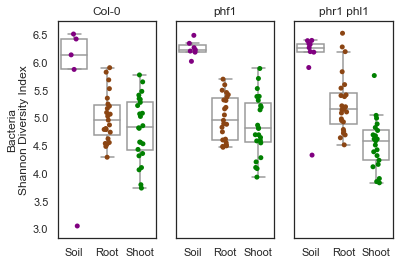

In [204]:
'''colors = ['purple', 'saddlebrown', 'green']
sns.set_style('white')
sns.set_palette(sns.color_palette(colors))
fig, axes = plt.subplots(1, 3, sharey=True)
ax = sns.boxplot(data=col, ax=axes[0], color='white', fliersize=0)
ax.set(ylabel='Bacteria\nShannon Diversity Index', title='Col-0')
sns.stripplot(data=col, ax=axes[0])
ab = sns.boxplot(data=phf, ax=axes[1], color='white', fliersize=0)
ab.set(title='phf1')
sns.stripplot(data=phf, ax=axes[1])
ass = sns.boxplot(data=phr, ax=axes[2], color='white', fliersize=0)
ass.set(title='phr1 phl1')
sns.stripplot(data=phr, ax=axes[2]);'''

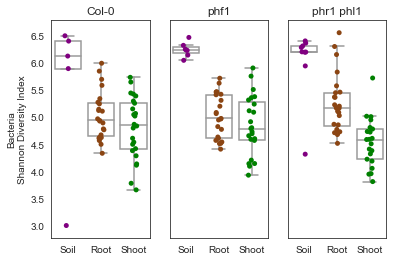

In [12]:
colors = ['purple', 'saddlebrown', 'green']
sns.set_style('white')
sns.set_palette(sns.color_palette(colors))
fig, axes = plt.subplots(1, 3, sharey=True)
ax = sns.boxplot(data=col, ax=axes[0], color='white', fliersize=0)
ax.set(ylabel='Bacteria\nShannon Diversity Index', title='Col-0')
sns.stripplot(data=col, ax=axes[0])
ab = sns.boxplot(data=phf, ax=axes[1], color='white', fliersize=0)
ab.set(title='phf1')
sns.stripplot(data=phf, ax=axes[1])
ass = sns.boxplot(data=phr, ax=axes[2], color='white', fliersize=0)
ass.set(title='phr1 phl1')
sns.stripplot(data=phr, ax=axes[2]);